# Experiment 1
Accuracy is low since the training data is small.

In [1]:
!pip install -U datasets
!pip install evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 21.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [2]:
import cv2
import random
import torch
import numpy as np
import evaluate
import matplotlib.pyplot as plt
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
from datasets import load_dataset, DatasetDict

In [3]:
torch.backends.cudnn.benchmark = True  # Optimize for consistent input sizes
torch.backends.cuda.matmul.allow_tf32 = True  # Enable TF32 for A100 GPUs

In [4]:
ds = load_dataset("uoft-cs/cifar10")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [5]:
ds

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [6]:
# training time on full dataset is too long
ds = DatasetDict({
    'train': ds['train'].select(range(5000)),  # Use first 30000 samples
    'test': ds['test'].select(range(500))      # Use first 3000 samples
})
ds

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 500
    })
})

In [7]:
ds['train'][0]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 0}

In [8]:
id2label = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

In [9]:
label2id = {label: i for i, label in enumerate(id2label.values())}

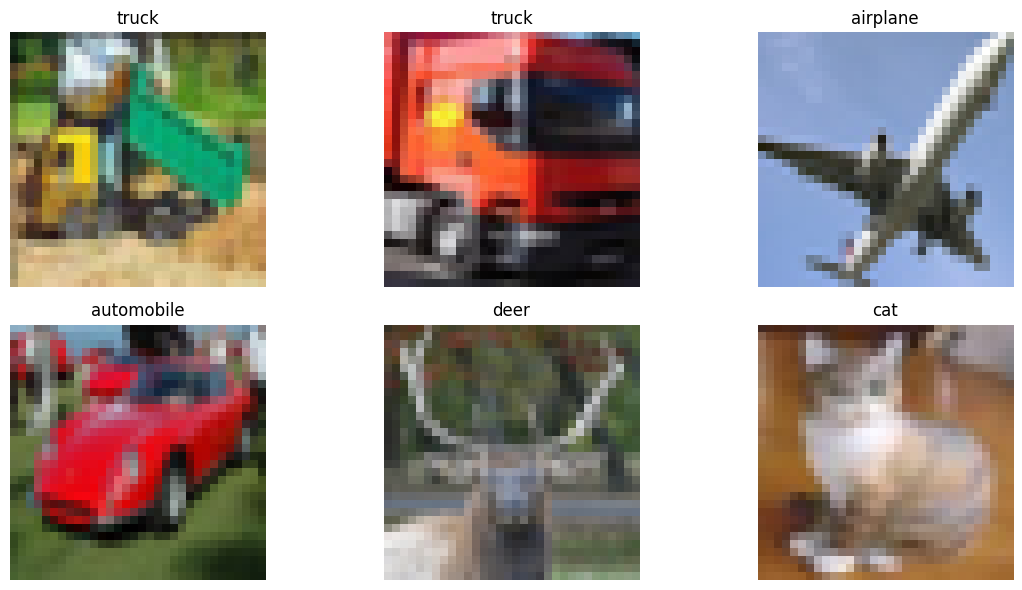

In [10]:
plt.figure(figsize=(12, 6))
for i in range(6):
  image = ds['train'][random.randint(0, len(ds['train']) - 1)]
  image_rgb = np.array(image['img'])

  plt.subplot(2, 3, i + 1)
  plt.title(id2label[image['label']])
  plt.imshow(image_rgb)
  plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
model_name = 'google/vit-base-patch16-224'

In [12]:
processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
    )

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
processor

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [14]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [15]:
def preprocess(data):
  inputs = processor(data['img'], return_tensors='pt')
  data['pixel_values'] = inputs['pixel_values']
  return data

ds = ds.map(preprocess, batched=True)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [16]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['img', 'label', 'pixel_values'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['img', 'label', 'pixel_values'],
        num_rows: 500
    })
})


In [17]:
accuracy = evaluate.load('accuracy')

def compute_metrics(p):
  preds = np.argmax(p.predictions, axis=1)
  return accuracy.compute(predictions=preds, references=p.label_ids)

In [18]:
training_arguments = TrainingArguments(
    output_dir='./vit-finetuned',
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    gradient_accumulation_steps=2,
    warmup_steps=500,
    logging_steps=50,
    eval_steps=50,
    eval_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=2,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_dir='./logs',
    report_to='none',
    fp16=True,
)


trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=ds['train'],
    eval_dataset=ds['test'],
    compute_metrics=compute_metrics
)

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.262998,0.136000
2,No log,1.892631,0.444000


TrainOutput(global_step=40, training_loss=2.2354297637939453, metrics={'train_runtime': 1240.8467, 'train_samples_per_second': 8.059, 'train_steps_per_second': 0.032, 'total_flos': 7.7497545904128e+17, 'train_loss': 2.2354297637939453, 'epoch': 2.0})

In [20]:
eval_results = trainer.evaluate()

In [21]:
eval_results

{'eval_loss': 1.8926308155059814,
 'eval_accuracy': 0.444,
 'eval_runtime': 49.6741,
 'eval_samples_per_second': 10.066,
 'eval_steps_per_second': 0.081,
 'epoch': 2.0}

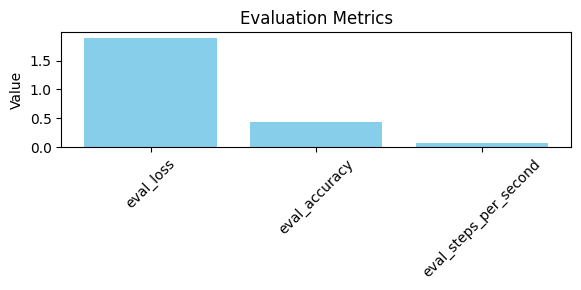

In [22]:
metric_keys = [k for k in eval_results.keys() if k.startswith("eval_") and "runtime" not in k and "samples" not in k]
metric_values = [eval_results[k] for k in metric_keys]

plt.figure(figsize=(6, 3))
plt.bar(metric_keys, metric_values, color='skyblue')
plt.title("Evaluation Metrics")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()